In [1]:
# trying to understand which strategy results in a higher revenue using PaxSim 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import Helper
import passengersim as pax

pax.__version__


'0.40'

In [2]:
# choosing the YAML files and saving the configuration
cfg = pax.Config.from_yaml([
    os.path.join("simulation_controls.yaml"),
    os.path.join("flights.yaml"),
    os.path.join("places.yaml"),
])

In [3]:
# Number of samples to generate
n_samples = 500

# Set the number of samples
cfg.simulation_controls.num_samples = n_samples
cfg.simulation_controls.random_seed = 42

cfg.carriers.AL1.rm_system = "rm_udp"

# Generate the samples
sim = pax.MultiSimulation(cfg)
summaryUEEE = sim.run() 

╭─────────────────────────────────────╮                                                                         
   │ licensed for Student User           │                                                                         
   │ until 2025-03-15 04:31:40+00:00 UTC │                                                                         
   │ maximum 600 legs in network         │                                                                         
   ╰─────────────────────────────────────╯

Output()

In [4]:
cfg.carriers.AL1.rm_system = "rm_leg"
# Generate the samples
sim = pax.MultiSimulation(cfg)
summaryEEEE = sim.run() 


Output()

In [5]:
from collections import defaultdict
dmd_by_seg, dmd = defaultdict(float), defaultdict(float)
tot_businessUEEE, tot_leisureUEEE, tot_UEEE = 0.0, 0.0, 0.0
for idx, row in summaryUEEE.demand_to_come.iterrows():
    k1 = (idx[1], idx[2], idx[3])  # trial, sample, segment
    k2 = (idx[1], idx[2])  # trial, sample
    d = float(row.iat[0])
    dmd_by_seg[k1] += d
    dmd[k2] += d
    if idx[3] == "business":
        tot_businessUEEE += d
    else:
        tot_leisureUEEE += d

    tot_UEEE += d

avg_businessUEEE, avg_leisureUEEE = tot_businessUEEE / len(dmd), tot_leisureUEEE / len(dmd)

raw_data = []
for key, val in dmd.items():
    key_b, key_l = (key[0], key[1], "business"), (key[0], key[1], "leisure")
    dmd_b, dmd_l = dmd_by_seg[key_b], dmd_by_seg[key_l]
    hi_b = 1 if dmd_b > avg_businessUEEE else 0
    hi_l = 1 if dmd_l > avg_leisureUEEE else 0
    hi_both = 1 if hi_b and hi_l else 0
    hi_neither = 0 if hi_b or hi_l else 1
    # print (key, val, dmd_b, hi_b, dmd_l, hi_l, hi_both, hi_neither)
    raw_data.append([val, dmd_b, dmd_l, hi_b, hi_l, hi_both, hi_neither])
DemandDF = pd.DataFrame(raw_data, columns = ["tot_dmd", "dmd_b", "dmd_l", "hi_b", "hi_l", "hi_both", "hi_neither"])

# Demand is same for both strategies since the random seed is same




In [6]:
# Get the priceable vs yieldable mix
Edf = summaryEEEE.carrier_history2.reset_index()
Udf = summaryUEEE.carrier_history2.reset_index()

# Divide the sold_priceable by sold columns to get the mix percent
Edf['priceable_mix'] = Edf['sold_priceable'] / Edf['sold']
Udf['priceable_mix'] = Udf['sold_priceable'] / Udf['sold']

# Filter for carrier 'AL1'
Edf = Edf[Edf['carrier'] == 'AL1']
Udf = Udf[Udf['carrier'] == 'AL1']

# Drop rows with NaN values
Edf = Edf.dropna(subset=['priceable_mix'])
Udf = Udf.dropna(subset=['priceable_mix'])

# Create a new DataFrame to store results
DF = pd.DataFrame()
DF['AL1 EEEE Rev'] = summaryEEEE.carrier_history.revenue['AL1']
DF['AL1 UEEE Rev'] = summaryUEEE.carrier_history.revenue['AL1']
DF['AL1 Rev Diff'] = DF['AL1 UEEE Rev'] - DF['AL1 EEEE Rev']
DF['AL1 UEEE Priceable Mix'] = Udf['priceable_mix'].values
DF['AL1 EEEE Priceable Mix'] = Edf['priceable_mix'].values
DF['Business Demand'] = DemandDF['dmd_b'].values
DF['Leisure Demand'] = DemandDF['dmd_l'].values
DF['Total Demand'] = DemandDF['tot_dmd'].values
DF['Revenue Difference Percent'] = (DF['AL1 Rev Diff'] / DF['AL1 EEEE Rev'].mean()) * 100


# Display the first few rows of the DataFrame
DF.head()

AL1 EEEE Rev  AL1 UEEE Rev  AL1 Rev Diff  \
iteration trial sample                                             
0         0     100         402439.0      399025.0       -3414.0   
                101         487421.0      523181.0       35760.0   
                102         529940.0      568488.0       38548.0   
                103         626747.0      638378.0       11631.0   
                104         589413.0      621262.0       31849.0   

                        AL1 UEEE Priceable Mix  AL1 EEEE Priceable Mix  \
iteration trial sample                                                   
0         0     100                   0.965841                0.970000   
                101                   0.974774                0.973351   
                102                   0.978842                0.980170   
                103                   0.982826                0.977103   
                104                   0.975789                0.975726   

                        Business Demand  Leisure Demand  Total Demand  \
iteration trial sample                                                  
0         0     100              1305.0          2335.0        3640.0   
                101              1605.0          2579.0        4184.0   
                102              1755.0          3445.0        5200.0   
                103              1853.0          3538.0        5391.0   
                104              1917.0          3618.0        5535.0   

                        Revenue Difference Percent  
iteration trial sample                              
0         0     100                      -0.636878  
                101                       6.670987  
                102                       7.191085  
                103                       2.169750  
                104                       5.941394

In [7]:
# export the DF as a CSV
DF.to_csv('SimulationData.csv')

In [2]:
DF = pd.read_csv('SimulationData.csv')

84.875 15.125
Data less than -2 std dev:  10
Data between -2 and -1 std dev:  112
Data between -1 and mean:  308
Data between mean and +1 std dev:  241
Data between +1 and +2 std dev:  107
Data greater than +2 std dev:  22


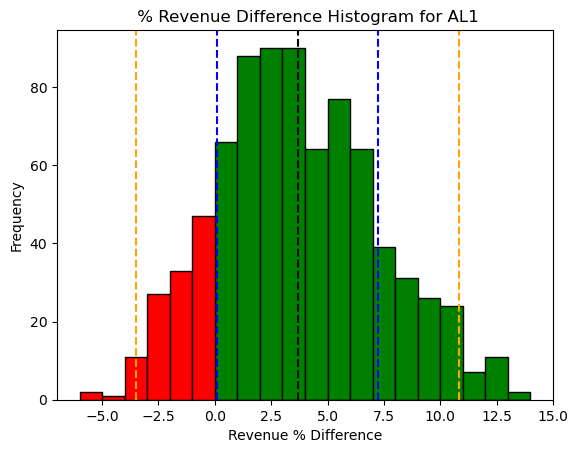

In [3]:
Helper.win_loss_histogram(DF['Revenue Difference Percent'], 'AL1', num_bins=10, strategy1='System 1', strategy2='System 2')


In [4]:
# implementing ML model to predict whether the revenue is higher for EEEE or UEEE 

# Try XGBoost
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define the features and target variable
features = ['AL1 UEEE Priceable Mix', 'AL1 EEEE Priceable Mix', 'Business Demand', 'Leisure Demand', 'Total Demand']
X = DF[features]
Y = DF['Revenue Difference Percent'] > 0

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
model = XGBClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 84.38%


<Figure size 1200x800 with 0 Axes>

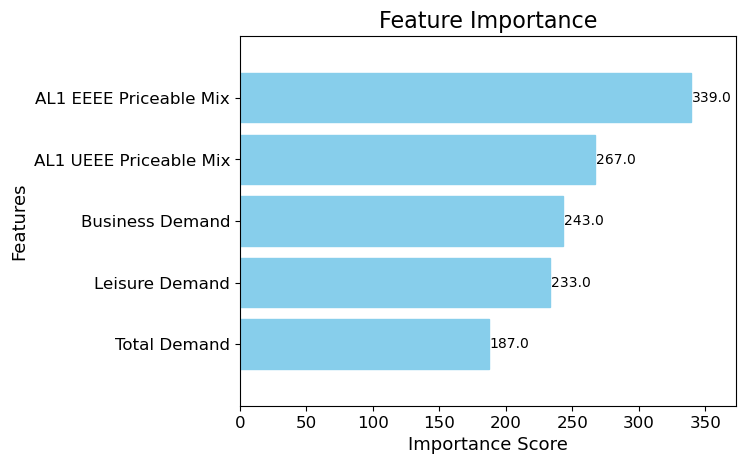

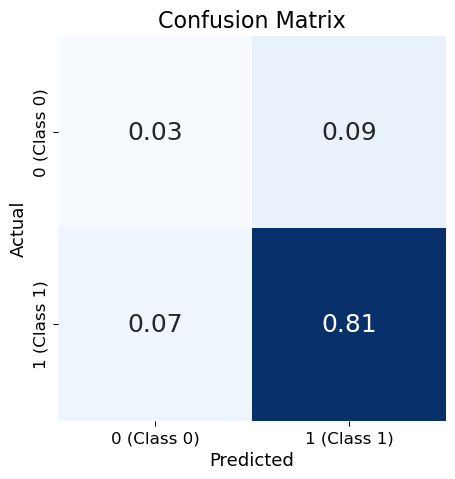

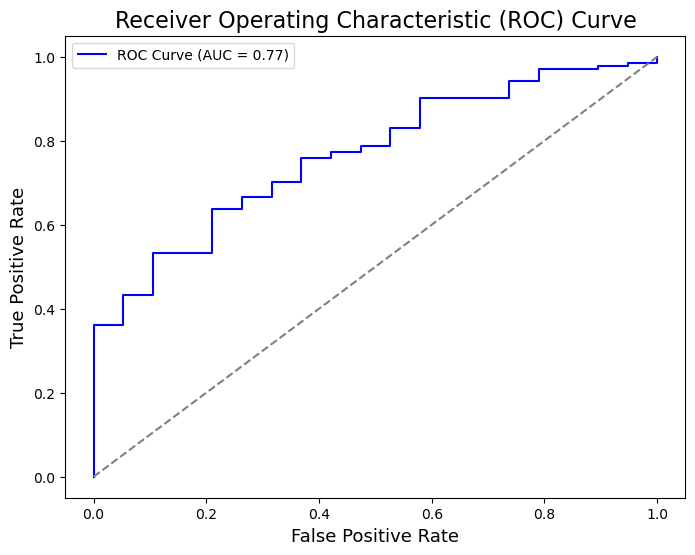

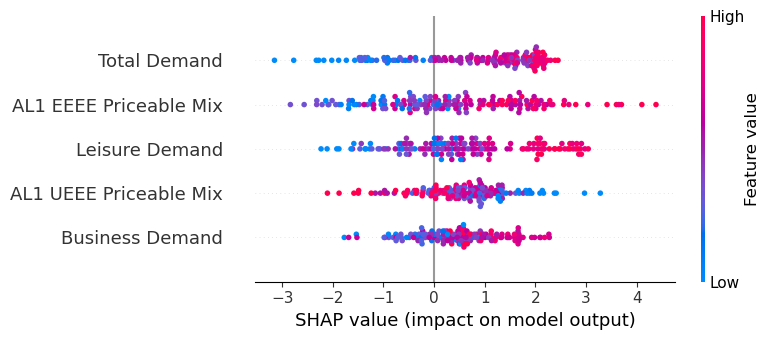

In [5]:
Helper.plot_model_evaluation(model, x_test, y_test)

The priceable mix for EEEE has a higher importance score than for UEEE. This suggests that the success of the EEEE strategy is more sensitive to the proportion of priceable demand compared to the UEEE strategy.

EEEE might be more effective in markets where priceable passengers (those willing to pay higher fares or less sensitive to price) dominate, as the strategy likely benefits from more precise demand segmentation.
    
The total demand has the lowest importance score, which implies that the absolute level of demand is less critical in determining which strategy performs better.

Strategy effectiveness seems to depend more on demand composition (business vs. leisure) and priceable mix rather than overall demand levels.



Idea: Develop adaptive strategies where the simulator dynamically selects between UEEE and EEEE based on real-time assessments of demand characteristics (priceable mix, business vs. leisure demand)